In [43]:
import pandas as pd
import numpy as np
import yfinance as yf  # We'll use this to get stock data.
import matplotlib.pyplot as plt

In [44]:
# Load the list of Nifty 200 stocks from a CSV file.
df = pd.read_csv("/content/ind_nifty200list.csv")
# Set the start and end dates for the stock data we want to analyze.
start_date = '2021-01-13'
end_date = '2024-02-13'
# Create a list to keep track of any stocks that we couldn't download data for.
failed_tickers = []

# Now, let's go through each stock and try to download its historical data.
for ticker in df['Tickers']:
    try:
        # Download the data using yfinance.
        data = yf.download(ticker, start=start_date, end=end_date)
        # If we didn't get any data, add the ticker to our failed list.
        if data.empty:
            failed_tickers.append(ticker)
    except Exception as e:
        # If there was an error, add the ticker to the failed list and tell us about it.
        failed_tickers.append(ticker)
        print(f"Error downloading data for {ticker}: {e}")

# Let's remove the stocks that we couldn't download data for.
df = df[~df['Tickers'].isin(failed_tickers)]  # We're using '~' to say "not in" the failed list.
# Reset the index of the DataFrame, just to keep things tidy.
df = df.reset_index(drop=True)
# Let's see what columns we have in our DataFrame.
actual_columns = df.columns.tolist()
print(actual_columns)

# Now, we'll pick out the specific financial features we want to use for clustering.
features = df[['ROE\xa0%', 'ROCE\xa0%', 'OPM\xa0%', 'Free Cash Flow\xa0Rs.Cr.', 'Piotski Scr', 'EPS dil growth', 'Div Yld\xa0%', 'Debt / Eq']]
features


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

['S.No.', 'Name', 'CMP Rs.', 'P/E', 'Mar Cap\xa0Rs.Cr.', 'Div Yld\xa0%', 'ROCE\xa0%', 'PEG', 'OPM\xa0%', 'Debt / Eq', 'ROE\xa0%', 'CMP / BV', 'CMP / FCF', 'EV / EBITDA', 'Free Cash Flow\xa0Rs.Cr.', 'Piotski Scr', 'EPS dil growth', 'Tickers']


,ROE %,ROCE %,OPM %,Free Cash Flow Rs.Cr.,Piotski Scr,EPS dil growth,Div Yld %,Debt / Eq
0,22.92,30.69,17.83,1168.40,9,19.98,0.44,0.01
1,14.15,9.95,35.76,-24498.67,3,-13.61,0.00,4.24
2,-18.93,0.25,10.61,600.27,2,0.00,0.00,2.44
3,14.15,17.27,14.54,1646.16,8,7.24,0.39,0.03
4,8.59,9.00,29.83,608.08,8,27.89,0.00,1.86
...,...,...,...,...,...,...,...,...
193,4.40,8.51,5.67,473.22,6,28.52,0.41,0.14
194,14.31,16.93,20.02,16972.80,8,6.91,1.91,0.24
195,3.11,5.81,60.61,8682.68,7,-42.92,0.00,8.23
196,1.12,1.14,3.62,444.00,7,19.55,0.00,0.05


In [45]:
from sklearn.preprocessing import StandardScaler
from os import X_OK

# We'll standardize the data to make sure all the features have equal importance in clustering.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  # This applies the standardization.
X_scaled

array([[ 0.06646891,  0.66017693, -0.50672138, ..., -0.04019259,
        -0.4660771 , -0.48657828],
       [-0.1999683 , -0.52858445,  0.24147433, ..., -0.68005107,
        -0.73782544,  0.63919181],
       [-1.2049561 , -1.08456252, -0.80800265, ..., -0.42079314,
        -0.73782544,  0.16014071],
       ...,
       [-0.53536931, -0.76587818,  1.2784327 , ..., -1.23837951,
        -0.73782544,  1.70108842],
       [-0.59582656, -1.0335501 , -1.09968631, ..., -0.04838369,
        -0.73782544, -0.4759327 ],
       [-0.00188728,  0.18157724, -0.01974737, ..., -0.34821616,
        -0.54019028, -0.48657828]])

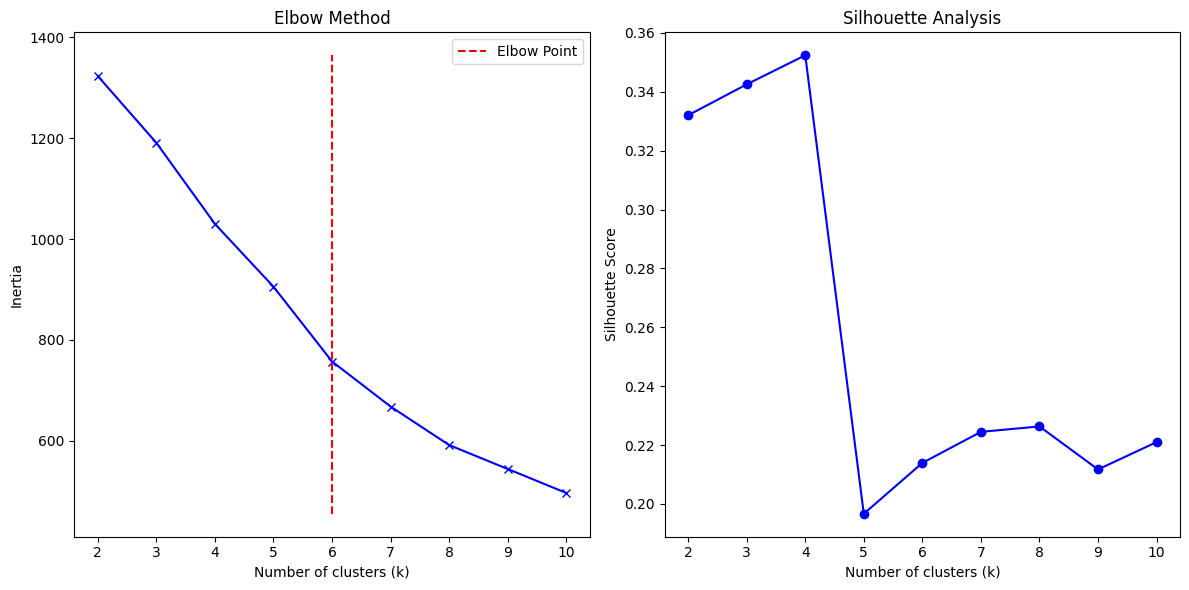

Optimal K from Elbow Method: 6


In [46]:
# We need the 'kneed' library to help us find the best number of clusters later on.
!pip install kneed
from sklearn.metrics import silhouette_score
from kneed import KneeLocator  # This will help us find the "elbow" in the elbow method
from sklearn.cluster import KMeans
# Initialize lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []

# Define a range of cluster numbers (K) to test
K = range(2, 11)  # Start from 2 clusters as Silhouette Score is not defined for 1 cluster

# Iterate through each cluster number
for k in K:
    # Create and fit the KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)

    # Append inertia to the list
    inertia.append(kmeans.inertia_)

    # Calculate and append Silhouette Score
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Find the elbow point using KneeLocator
elbow_locator = KneeLocator(K, inertia, curve="convex", direction="decreasing")
optimal_k_elbow = elbow_locator.elbow

# Plot the elbow curve and Silhouette Scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Create a subplot for the elbow curve
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.vlines(optimal_k_elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r', label='Elbow Point')
plt.legend()

plt.subplot(1, 2, 2)  # Create a subplot for Silhouette Scores
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

print(f"Optimal K from Elbow Method: {optimal_k_elbow}")

In [47]:

kmeans = KMeans(n_clusters=optimal_k_elbow, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)# Assign each stock to a cluster.

# Centroids of the clusters
centroids = kmeans.cluster_centers_

# Inertia of the model
model_inertia = kmeans.inertia_

# Display the DataFrame with cluster assignments
df


,S.No.,Name,CMP Rs.,P/E,Mar Cap Rs.Cr.,Div Yld %,ROCE %,PEG,OPM %,Debt / Eq,ROE %,CMP / BV,CMP / FCF,EV / EBITDA,Free Cash Flow Rs.Cr.,Piotski Scr,EPS dil growth,Tickers,Cluster
0,68,A B B,5460.30,68.57,115708.34,0.44,30.69,3.43,17.83,0.01,22.92,18.25,152.46,45.96,1168.40,9,19.98,ABB.NS,1
1,171,Aditya Birla Cap,159.25,11.33,41511.62,0.00,9.95,0.35,35.76,4.24,14.15,1.44,-2.31,11.04,-24498.67,3,-13.61,ABCAPITAL.NS,4
2,192,Aditya Bir. Fas.,260.00,-45.14,29634.24,0.00,0.25,1.70,10.61,2.44,-18.93,6.79,74.23,21.91,600.27,2,0.00,ABFRL.NS,1
3,182,ACC,1916.40,14.98,35987.49,0.39,17.27,2.07,14.54,0.03,14.15,2.16,961.78,8.67,1646.16,8,7.24,ACC.NS,1
4,96,Adani Energy Sol,744.85,52.06,89477.44,0.00,9.00,3.89,29.83,1.86,8.59,4.22,-652.51,16.88,608.08,8,27.89,ADANIENSOL.NS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,172,Voltas,1251.70,58.47,41416.86,0.41,8.51,-4.30,5.67,0.14,4.40,6.60,125.20,36.47,473.22,6,28.52,VOLTAS.NS,1
194,19,Wipro,307.50,26.02,321979.43,1.91,16.93,6.71,20.02,0.24,14.31,3.93,25.59,15.66,16972.80,8,6.91,WIPRO.NS,0
195,140,Yes Bank,18.21,26.33,57093.55,0.00,5.81,-4.77,60.61,8.23,3.11,1.24,32.16,15.61,8682.68,7,-42.92,YESBANK.NS,1
196,35,Zomato Ltd,217.95,317.28,210329.35,0.00,1.14,19.78,3.62,0.05,1.12,9.83,-504.31,132.28,444.00,7,19.55,ZOMATO.NS,1


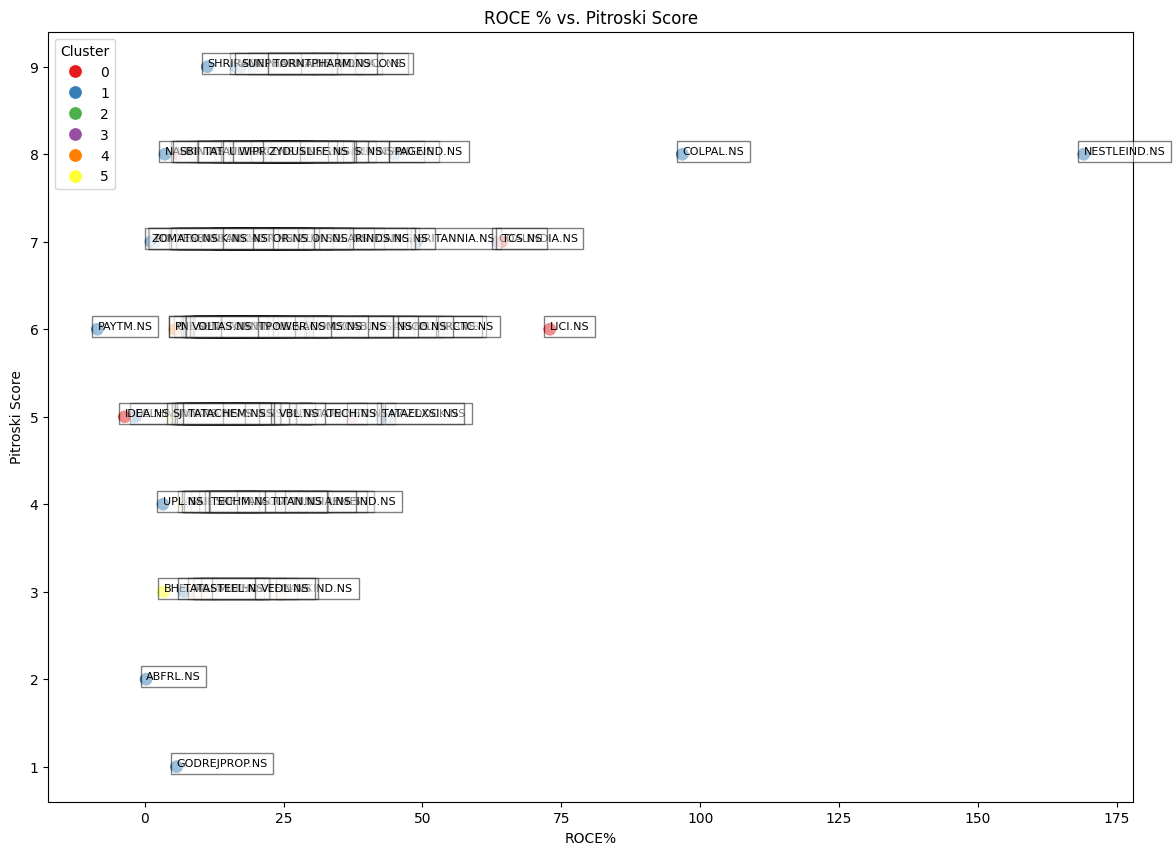

In [48]:
#Creating a scatter plot to visualize the clusters (using ROCE and Piotski Score).
import seaborn as sns #used here to generate a scatter plot.
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df, x='ROCE\xa0%', y='Piotski Scr', hue='Cluster', palette='Set1', s=100)

# Adding company names to the plot though Tickers
for i in range(df.shape[0]):
    plt.text(x=df['ROCE\xa0%'][i], y=df['Piotski Scr'][i], s=df['Tickers'][i],
             fontdict=dict(color='black', size=8), bbox=dict(facecolor='white', alpha=0.5))

plt.title('ROCE % vs. Pitroski Score')
plt.xlabel('ROCE%')
plt.ylabel('Pitroski Score')
plt.show()


In [49]:
# Calculate cluster means for relevant features
cluster_means = df.groupby('Cluster')[features.columns].mean()

print(cluster_means)


             ROE %     ROCE %      OPM %  Free Cash Flow Rs.Cr.  Piotski Scr  \
Cluster                                                                        
0        23.616154  21.939615  28.820385           23646.365385     6.576923   
1        21.640567  20.750426  25.338085            1961.992482     6.404255   
2        20.220000  10.885000  76.027500          -74911.232500     5.250000   
3        18.800000   7.600000  30.370000          153675.820000     6.000000   
4        11.455714  11.464286  40.720000          -26847.655714     3.857143   
5        13.671053   8.865263  52.272632           -7954.915789     5.105263   

         EPS dil growth  Div Yld %  Debt / Eq  
Cluster                                        
0             22.413077   2.406154   2.052308  
1             22.680709   0.973546   1.201135  
2             26.707500   1.980000   5.812500  
3             57.020000   0.800000   6.450000  
4              7.187143   0.978571   3.494286  
5             19.943684

In [50]:
# We are optimizing portfolios based on our clusters here
from scipy.optimize import minimize  # This is for optimizing our portfolios.
# A dictionary is created to store the results for each cluster.
all_cluster_results = {}

# Defining functions to calculate portfolio performance and find the optimal weights.
def portfolio_performance(weights, mean_returns, cov_matrix):
    # This function calculates the portfolio's return, risk, and Sharpe ratio.
    portfolio_return = np.sum(mean_returns * weights) * 252  # Annualized return (assuming 252 trading days).
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualized standard deviation.
    sharpe_ratio = portfolio_return / portfolio_std  # Sharpe ratio (risk-adjusted return).
    return portfolio_return, portfolio_std, sharpe_ratio

def sum_weights(weights):
    # This function makes sure the portfolio weights add up to 1.
    return np.sum(weights) - 1

def max_sharpe_ratio(weights, mean_returns, cov_matrix):
    # This is our objective function: we want to maximize the Sharpe ratio.
    return portfolio_performance(weights, mean_returns, cov_matrix)[2]  # Return the Sharpe ratio.

def optimize_portfolio(mean_returns, cov_matrix):
    # This function uses optimization to find the best portfolio weights.
    num_assets = len(mean_returns)  # Number of stocks in the portfolio.
    args = (mean_returns, cov_matrix)  # Arguments for the objective function.
    constraints = {'type': 'eq', 'fun': sum_weights}  # Constraint: weights must sum to 1.
    bounds = [(0, 1)] * num_assets  # Each weight can be between 0 and 1.
    result = minimize(max_sharpe_ratio, num_assets * [1. / num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)  # Use the SLSQP solver to find the optimal weights.
    return result

# We loop through each cluster and optimize a portfolio for it.
for cluster_id in df['Cluster'].unique():
    # Get the stocks that belong to this cluster.
    cluster_stocks = df[df['Cluster'] == cluster_id].Tickers.tolist()
    # Download the historical data for these stocks.
    cluster_data = yf.download(cluster_stocks, start=start_date, end=end_date)['Close']
    # Calculate the daily returns.
    cluster_returns = cluster_data.pct_change().dropna()
    # Calculate the average returns and the covariance matrix.
    mean_returns = cluster_returns.mean()
    cov_matrix = cluster_returns.cov()
    # Find the optimal portfolio weights.
    optimal_weights = optimize_portfolio(mean_returns, cov_matrix)['x']  # Get the optimal weights from the optimization result.
    # Store the results in a DataFrame.
    portfolio_df = pd.DataFrame({
        'Stock': cluster_stocks,
        'Optimal Weight': optimal_weights
    })
    all_cluster_results[cluster_id] = portfolio_df

# To see the portfolo results for all the clusters.
all_cluster_results

[*********************100%***********************]  141 of 141 completed
<ipython-input-50-d987ffe7e3ad>:39: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  cluster_returns = cluster_data.pct_change().dropna()
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  19 of 19 completed
<ipython-input-50-d987ffe7e3ad>:39: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  cluster_returns = cluster_data.pct_change().dropna()
[*********************100%***********************]  4 of 4 completed
[*********************100%******************

{1:              Stock  Optimal Weight
 0           ABB.NS    3.921255e-12
 1         ABFRL.NS    4.197378e-12
 2           ACC.NS    0.000000e+00
 3    ADANIENSOL.NS    2.529538e-12
 4    ADANIGREEN.NS    0.000000e+00
 ..             ...             ...
 136        VEDL.NS    0.000000e+00
 137      VOLTAS.NS    0.000000e+00
 138     YESBANK.NS    0.000000e+00
 139      ZOMATO.NS    0.000000e+00
 140   ZYDUSLIFE.NS    4.673086e-12
 
 [141 rows x 2 columns],
 4:           Stock  Optimal Weight
 0  ABCAPITAL.NS    0.000000e+00
 1  JSWENERGY.NS    3.941292e-15
 2      LODHA.NS    8.285039e-15
 3     M&MFIN.NS    1.000000e+00
 4    MANKIND.NS    0.000000e+00
 5        PNB.NS    6.022960e-15
 6      TECHM.NS    0.000000e+00,
 5:             Stock  Optimal Weight
 0     ADANIENT.NS    0.000000e+00
 1     ASHOKLEY.NS    3.781976e-01
 2     AXISBANK.NS    3.265528e-12
 3   BANKBARODA.NS    0.000000e+00
 4    BANKINDIA.NS    6.192639e-13
 5         BHEL.NS    0.000000e+00
 6        HUDCO.NS    

In [51]:
all_cluster_results_df = pd.DataFrame()  # Initialize an empty DataFrame

# Iterate through each cluster and append its data to the DataFrame
for cluster_id, portfolio_df in all_cluster_results.items():
    portfolio_df['Cluster'] = cluster_id  # Add a 'Cluster' column
    all_cluster_results_df = pd.concat([all_cluster_results_df, portfolio_df], ignore_index=True)

# Display the DataFrame
all_cluster_results_df

,Stock,Optimal Weight,Cluster
0,ABB.NS,3.921255e-12,1
1,ABFRL.NS,4.197378e-12,1
2,ACC.NS,0.000000e+00,1
3,ADANIENSOL.NS,2.529538e-12,1
4,ADANIGREEN.NS,0.000000e+00,1
...,...,...,...
193,TATAMOTORS.NS,1.273981e-14,0
194,TCS.NS,0.000000e+00,0
195,UNIONBANK.NS,4.721223e-14,0
196,WIPRO.NS,0.000000e+00,0


In [52]:
# As we need the risk-free rate to calculate Sharpe and Treynor ratios,
# I used fred api to get latest data (using the 10-Year Indian Government Bond yield).
!pip install fredapi
from fredapi import Fred  # This lets us access economic data from FRED.
fred_api_key = "645d616b79d86af6f10937a643c61f5b" # the fred api key
fred = Fred(api_key=fred_api_key)  # Create a Fred object to access the API.

def get_latest_10_year_bond_yield():
    # This function fetches the latest yield from FRED.
    series_data = fred.get_series('INDIRLTLT01STM')  # Get the data for the 10-Year Indian Government Bond yield.
    risk_free_rate = series_data.iloc[-1]  # The latest yield is the last value in the series.
    return risk_free_rate / 100

risk_free_rate = get_latest_10_year_bond_yield()
print(f"Latest 10-Year Indian Government Bond Yield: {risk_free_rate}")

Latest 10-Year Indian Government Bond Yield: 0.0677


In [53]:
# This section is to caluclate performance metrics for our portfolios and compare them to the Nifty 200 index.
import statsmodels.api as sm  # This is for statistical modeling, used to caclculate beta here.
import requests  # We'll use this to make requests to upstox api for nifty 200 data.
cluster_metrics = []  # We'll store the metrics for each cluster here.
cluster_weighted_returns = {}  # We'll store the weighted returns for each cluster here
aligned_returns_by_cluster = {}
aligned_data_by_cluster = {}
# Download the Nifty 200 data using the Upstox API.
url = f'https://api.upstox.com/v2/historical-candle/NSE_INDEX|Nifty 200/day/{end_date}/{start_date}'
headers = {'Accept': 'application/json'}  # Set the headers for the API request.
response = requests.get(url, headers=headers)  # Make the request.

if response.status_code == 200:  # Check if the request was successful.
    data = response.json()  # Get the data from the response.
    closing_prices = [candle[4] for candle in data['data']['candles']]  # Extract the closing prices.
    dates = [candle[0][:10] for candle in data['data']['candles']]  # Extract the dates.
    nifty_data = pd.DataFrame({'Close': closing_prices}, index=pd.to_datetime(dates))  # Create a DataFrame for the Nifty 200 data.
else:
    print(f"Error: {response.status_code} - {response.text}")  # Print an error message if the request failed.

# Running a loop through each cluster and calculate the metrics.
for cluster_id in df['Cluster'].unique():
    # Get the stocks for this cluster.
    cluster_stocks = df[df['Cluster'] == cluster_id].Tickers.tolist()
    # Download their historical data.
    cluster_data = yf.download(cluster_stocks, start=start_date, end=end_date)['Close']

    # We need to make sure the cluster data and Nifty data are aligned by date.
    common_dates = cluster_data.index.intersection(nifty_data.index)  # Find the common dates.
    aligned_cluster_data = cluster_data.reindex(common_dates)  # Reindex the cluster data.
    aligned_data_by_cluster[cluster_id] = aligned_cluster_data
    aligned_nifty_data = nifty_data.reindex(common_dates)  # Reindex the Nifty data.
    nifty_returns = aligned_nifty_data['Close'].pct_change().dropna()  # Calculate the Nifty returns.
    cluster_returns = aligned_cluster_data.pct_change() # Calculate the cluster returns.
    aligned_cluster_returns = cluster_returns.reindex(nifty_returns.index)  # Align the cluster returns with the Nifty returns.
    aligned_returns_by_cluster[cluster_id] = aligned_cluster_returns

    # Calculate the weighted returns for the cluster's portfolio.
    optimal_weights = all_cluster_results[cluster_id]['Optimal Weight'].values  # Get the optimal weights.
    weighted_returns = (aligned_cluster_returns * optimal_weights).sum(axis=1)  # Apply the weights to the returns.
    cluster_weighted_returns[cluster_id] = weighted_returns  # Store the weighted returns.

    # Calculate the portfolio's annualized return.
    annualised_portfolio_return = cluster_weighted_returns[cluster_id].mean() * 252
    # Calculate the portfolio's risk (standard deviation).
    new_var = aligned_cluster_returns.cov()  # Get the covariance matrix.
    portfolio_std = np.sqrt(np.dot(optimal_weights.T, np.dot(new_var, optimal_weights))) * np.sqrt(252)  # Calculate the standard deviation.
    # Calculate the reward-to-risk ratio.
    reward_to_risk = annualised_portfolio_return / portfolio_std

    # Calculate the portfolio's beta (systematic risk).
    X = sm.add_constant(nifty_returns)  # Add a constant term for the regression.
    model = sm.OLS(cluster_weighted_returns[cluster_id], X).fit()  # Fit an OLS regression model.
    beta = model.params['Close']  # Get the beta coefficient.

    # Calculate the Sharpe ratio (risk-adjusted return).
    sharpe_ratio = (annualised_portfolio_return - risk_free_rate) / portfolio_std
    # Calculate the Treynor ratio (risk-adjusted return using beta).
    treynor_ratio = (annualised_portfolio_return - risk_free_rate) / beta

    # Add the metrics to our list.
    cluster_metrics.append([cluster_id, reward_to_risk, sharpe_ratio, treynor_ratio, beta])

# Create a DataFrame to display the cluster metrics.
metrics_df = pd.DataFrame(cluster_metrics, columns=['Cluster', 'Reward to Risk Ratio', 'Sharpe Ratio', 'Treynor Ratio', 'Beta'])
metrics_df

[*********************100%***********************]  141 of 141 completed
<ipython-input-53-e97bc88a064e>:34: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  cluster_returns = aligned_cluster_data.pct_change() # Calculate the cluster returns.
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  19 of 19 completed
<ipython-input-53-e97bc88a064e>:34: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  cluster_returns = aligned_cluster_data.pct_change() # Calculate the cluster returns.
[*********************100%***********************

,Cluster,Reward to Risk Ratio,Sharpe Ratio,Treynor Ratio,Beta
0,1,1.162603,0.733224,0.161742,0.714762
1,4,0.565853,0.388206,0.099483,1.487121
2,5,0.328128,0.017087,0.003550,1.047519
3,2,0.481201,0.257448,0.058190,1.338643
4,0,-0.382182,-0.569695,-0.168483,1.220798
5,3,0.953358,0.672784,0.147446,1.100994


Cluster 1 Final Cumulative Return: 0.5535578515016156
Cluster 4 Final Cumulative Return: 0.6512062624035504
Cluster 5 Final Cumulative Return: 0.21567417437337702
Cluster 2 Final Cumulative Return: 0.43967433965661606
Cluster 0 Final Cumulative Return: -0.4166871907837203
Cluster 3 Final Cumulative Return: 0.6946743564431498
Nifty 200 Final Cumulative Return: 0.48751137940357137


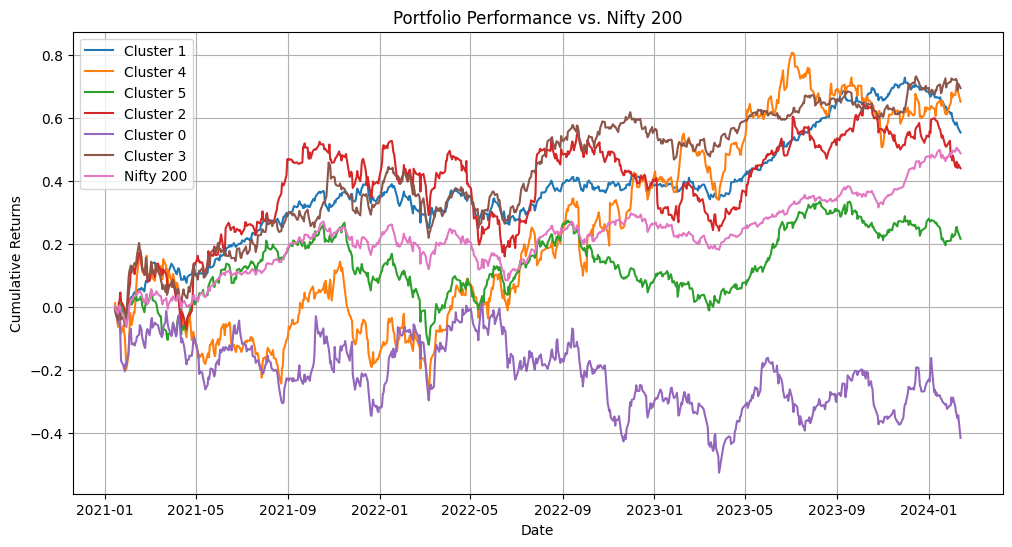

In [54]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
for cluster_id, weighted_returns in cluster_weighted_returns.items():
    plt.plot(weighted_returns.cumsum(), label=f"Cluster {cluster_id}")
    # Calculate and print the final cumulative return
    final_cumulative_return = weighted_returns.cumsum().iloc[-1]  # Get the last value
    print(f"Cluster {cluster_id} Final Cumulative Return: {final_cumulative_return}")

plt.plot(nifty_returns.cumsum(), label="Nifty 200")
# Calculate and print the final cumulative return for Nifty 200
nifty_final_cumulative_return = nifty_returns.cumsum().iloc[-1] # Get the final cumulative return for the Nifty 200.
print(f"Nifty 200 Final Cumulative Return: {nifty_final_cumulative_return}")


plt.title("Portfolio Performance vs. Nifty 200")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
def calculate_var(returns, confidence_level=0.99):
  """Calculates Value at Risk (VaR) for a given set of returns.

  VaR represents the maximum potential loss in the value of a portfolio
  over a given time period for a specified confidence level.
  For example, a 99% confidence level VaR of -0.05 means there is a 1% chance
  that the portfolio will lose more than 5% of its value over the specified time horizon.

  Args:
    returns: A pandas Series or numpy array of portfolio returns.
    confidence_level: The confidence level for VaR calculation (default: 0.99).

  Returns:
    The VaR value at the specified confidence level.
  """
  # Calculate VaR using the percentile method
  # This finds the return value at the specified percentile,
  # which represents the VaR.
  return np.percentile(returns, 100 * (1 - confidence_level))

for cluster_id, returns in cluster_weighted_returns.items():
  # Calculate and print VaR for each cluster
  var = calculate_var(returns, confidence_level=0.99)
  print(f"Cluster {cluster_id} VaR (99% confidence): {var:.4f}")

Cluster 1 VaR (99% confidence): -0.0257
Cluster 4 VaR (99% confidence): -0.0584
Cluster 5 VaR (99% confidence): -0.0349
Cluster 2 VaR (99% confidence): -0.0555
Cluster 0 VaR (99% confidence): -0.0726
Cluster 3 VaR (99% confidence): -0.0408
